# Step 1: Explore Data

In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

src_train_dir = '../input/careium-nutrition-5k/GP/Train'
src_test_dir = '../input/careium-nutrition-5k/GP/Test'
src_main_components_csv = '../input/careium-nutrition-5k/GP/main_5_components_combined_dishes.csv'

# Exploring Train files
tr_path, tr_dirs, tr_files = next(os.walk(src_train_dir))
print("Train Directory # of files: ", len(tr_files))

# Exploring Test files
tst_path, tst_dirs, tst_files = next(os.walk(src_test_dir))
print("Test Directory # of files: ", len(tst_files))

# Exploring csv file
df_alldata = pd.read_csv(src_main_components_csv)
print("csv file # of samples: ", len(df_alldata))
print('\n**********\n')
print('CSV file content:\n', df_alldata.head(2))

Train Directory # of files:  2771
Test Directory # of files:  743
csv file # of samples:  5006

**********

CSV file content:
            dish_id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1561662216      300.794281         193  12.387489    28.21829   
1  dish_1562688426      137.569992          88   8.256000     5.19000   

   total_protein  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  ...  \
0       18.63397         NaN         NaN         NaN         NaN  ...   
1       10.29700         NaN         NaN         NaN         NaN  ...   

   Unnamed: 164  Unnamed: 165  Unnamed: 166  Unnamed: 167  Unnamed: 168  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   Unnamed: 169  Unnamed: 170  Unnamed: 171  Unnamed: 172  Unnamed: 173  
0           NaN           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN  

# Step 2: Data Preparation

### Step 2.1: Data Normalization

In [2]:
import numpy as np
import pandas as pd

df_alldata = pd.read_csv(src_main_components_csv)
df_alldata = df_alldata.iloc[:, 0:6]
df_alldata.iloc[:, 1:5] = np.asarray(df_alldata.iloc[:, 1:5]).astype(np.float32)

# Normalizing outputs in range [0-1]
calories_max = df_alldata.iloc[:, 1].max()
mass_max = df_alldata.iloc[:, 2].max()
fat_max = df_alldata.iloc[:, 3].max()
carb_max = df_alldata.iloc[:, 4].max()
protein_max = df_alldata.iloc[:, 5].max()

df_alldata.iloc[:, 1] = df_alldata.iloc[:, 1] / calories_max
df_alldata.iloc[:, 2] = df_alldata.iloc[:, 2] / mass_max
df_alldata.iloc[:, 3] = df_alldata.iloc[:, 3] / fat_max
df_alldata.iloc[:, 4] = df_alldata.iloc[:, 4] / carb_max
df_alldata.iloc[:, 5] = df_alldata.iloc[:, 5] / protein_max

outputs_max_values = {'max_calorie': [calories_max], 'max_mass': [mass_max], 
                      'max_fat': [fat_max], 'max_carb': [carb_max], 'max_protein': [protein_max]} 
df_outputs_max_values = pd.DataFrame(outputs_max_values)
df_outputs_max_values.to_csv("./outputs_max_values.csv", index=False)
print("Outputs MAX values: \n", df_outputs_max_values)

Outputs MAX values: 
    max_calorie  max_mass     max_fat    max_carb  max_protein
0   9485.81543    7975.0  875.541016  844.568604   147.491821


In [3]:
# adding full image name column...
df_alldata['dishimage'] = df_alldata["dish_id"] + ".png"
print("df_alldata: ")
df_alldata.head(3)

df_alldata: 


,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,dishimage
0,dish_1561662216,0.031710,0.024201,0.014148,0.033411,0.126339,dish_1561662216.png
1,dish_1562688426,0.014503,0.011034,0.009430,0.006145,0.069814,dish_1562688426.png
2,dish_1561662054,0.044217,0.036614,0.027227,0.031201,0.175675,dish_1561662054.png


### Step 2.2: Train-Valid-Test Split

In [4]:
import os
import shutil
import random
import glob

# setting base directory for train-valid splitting
base_dir = './nutrition-data/'

# creating three folders' paths (train, valid and test)
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# remove base directory if exists
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
    
os.mkdir(base_dir)

# Organize data into train, valid, test dirs
shutil.copytree(src_train_dir, train_dir)
shutil.copytree(src_test_dir, test_dir)

valid_num_samples = 400
os.mkdir(valid_dir)

# move random samples from test data to be used as validation data 
for img in random.sample(glob.glob(test_dir + "/*"), valid_num_samples):
    shutil.move(img, valid_dir)

print("# of train samples: ", len(os.listdir(train_dir)))
print("# of valid samples: ", len(os.listdir(valid_dir)))
print("# of test  samples: ", len(os.listdir(test_dir)))

# of train samples:  2771
# of valid samples:  400
# of test  samples:  343


In [5]:
# Creating train, valid, test dataframes and separate csv files.
df_train = pd.DataFrame(columns=df_alldata.columns)
df_valid = pd.DataFrame(columns=df_alldata.columns)
df_test = pd.DataFrame(columns=df_alldata.columns)

df_alldata = df_alldata.sample(frac=1) # shuffles all data

train_files = os.listdir(train_dir)
valid_files = os.listdir(valid_dir)
test_files = os.listdir(test_dir)

for idx in df_alldata.index:
    if df_alldata.iloc[idx]['dishimage'] in train_files:
        df_train = df_train.append(df_alldata.iloc[idx])
    if df_alldata.iloc[idx]['dishimage'] in valid_files:
        df_valid = df_valid.append(df_alldata.iloc[idx])
    if df_alldata.iloc[idx]['dishimage'] in test_files:
        df_test = df_test.append(df_alldata.iloc[idx])
        
df_train.to_csv(os.path.join(base_dir, 'train_data.csv'), index=False)
df_valid.to_csv(os.path.join(base_dir, 'valid_data.csv'), index=False)
df_test.to_csv(os.path.join(base_dir, 'test_data.csv'), index=False)

### Step 2.3: Data Cleaning

In [6]:
def remove_useless_inputs(files, path, df):
    for img in files:
        if img not in df['dishimage'].to_list():
            img_path = os.path.join(path, img) 
            if os.path.exists(img_path):
                os.remove(path + "/" + img)

In [7]:
print("Number of Train Images Before Removal: ", len(train_files))
print("Number of Valid Images Before Removal: ", len(valid_files))
print("Number of Test  Images Before Removal: ", len(test_files))
remove_useless_inputs(train_files, train_dir, df_train)
remove_useless_inputs(valid_files, valid_dir, df_valid)
remove_useless_inputs(test_files, test_dir, df_test)
train_files = os.listdir(train_dir)
valid_files = os.listdir(valid_dir)
test_files = os.listdir(test_dir)
print("************************************")
print("Number of Train Images After Removal: ", len(train_files))
print("Number of Valid Images After Removal: ", len(valid_files))
print("Number of Test  Images After Removal: ", len(test_files))

Number of Train Images Before Removal:  2771
Number of Valid Images Before Removal:  400
Number of Test  Images Before Removal:  343
************************************
Number of Train Images After Removal:  2755
Number of Valid Images After Removal:  395
Number of Test  Images After Removal:  340


# Step 3: Deep Learning with Data Augmentation

### Step 3.1: Data Augmentation

In [8]:
IMG_DIMN = 224  # 224x244
BATCH_SIZE = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
labels = ["total_calories", "total_mass", "total_fat", "total_carb", "total_protein"]

In [9]:
train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   brightness_range=[0.7, 1.0],
                                   shear_range=0.15,
                                   horizontal_flip=True)

train_batches = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=train_dir,
                                                  x_col="dishimage",
                                                  y_col=labels,
                                                  target_size=(IMG_DIMN, IMG_DIMN),
                                                  class_mode="raw",
                                                  batch_size=BATCH_SIZE)

Found 2755 validated image filenames.


In [10]:
valid_datagen = ImageDataGenerator(rescale = 1/255.0)

valid_batches = valid_datagen.flow_from_dataframe(dataframe=df_valid,
                                                  directory=valid_dir,
                                                  x_col="dishimage",
                                                  y_col=labels,
                                                  target_size=(IMG_DIMN, IMG_DIMN),
                                                  class_mode="raw",
                                                  batch_size=BATCH_SIZE)

Found 395 validated image filenames.


In [11]:
import matplotlib.pyplot as plt

# this function will plot images in the form of a grid with 1 row and 5 columns where images are placed in the first batch
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

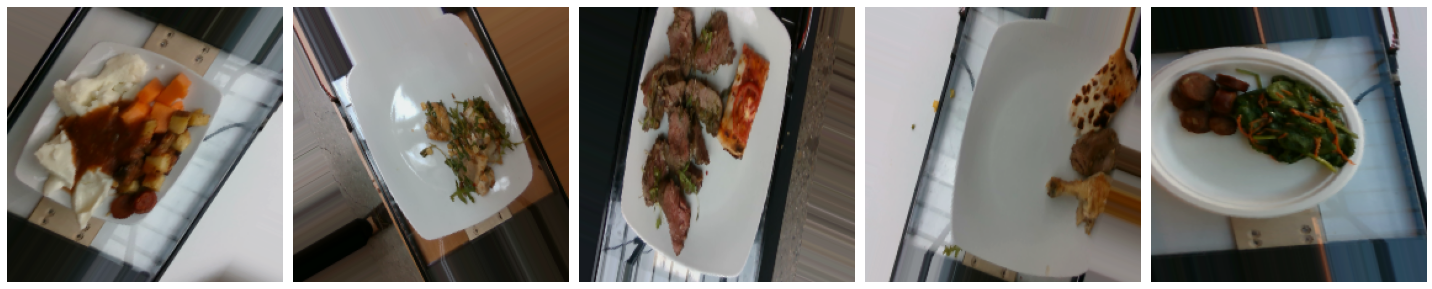

In [12]:
imgs, labels = next(train_batches)
plotImages(imgs)
# print(labels)

### Step 3.2: Building the Pre-trained Model

In [13]:
import tensorflow as tf

mobileNet = tf.keras.applications.mobilenet.MobileNet()

2022-06-28 14:50:22.925710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 14:50:23.029218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 14:50:23.030046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 14:50:23.031324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

17235968/17225924 [==============================] - 0s 0us/step


In [14]:
mobileNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization

x = mobileNet.layers[-5].output
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(.5)(x)

FC1 = Dense(512, activation='relu')(x)
FC2 = Dense(512, activation='relu')(FC1)
FC3 = Dense(512, activation='relu')(FC2)

out0 = Dense(units=1, activation='linear', name='total_calories_neuron')(FC3)
out1 = Dense(units=1, activation='linear', name='total_mass_neuron')(FC3)
out2 = Dense(units=1, activation='linear', name='total_fat_neuron')(FC3)
out3 = Dense(units=1, activation='linear', name='total_carb_neuron')(FC3)
out4 = Dense(units=1, activation='linear', name='total_protein_neuron')(FC3)

model = Model(inputs=mobileNet.input, outputs=[out0, out1, out2, out3, out4])

In [16]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

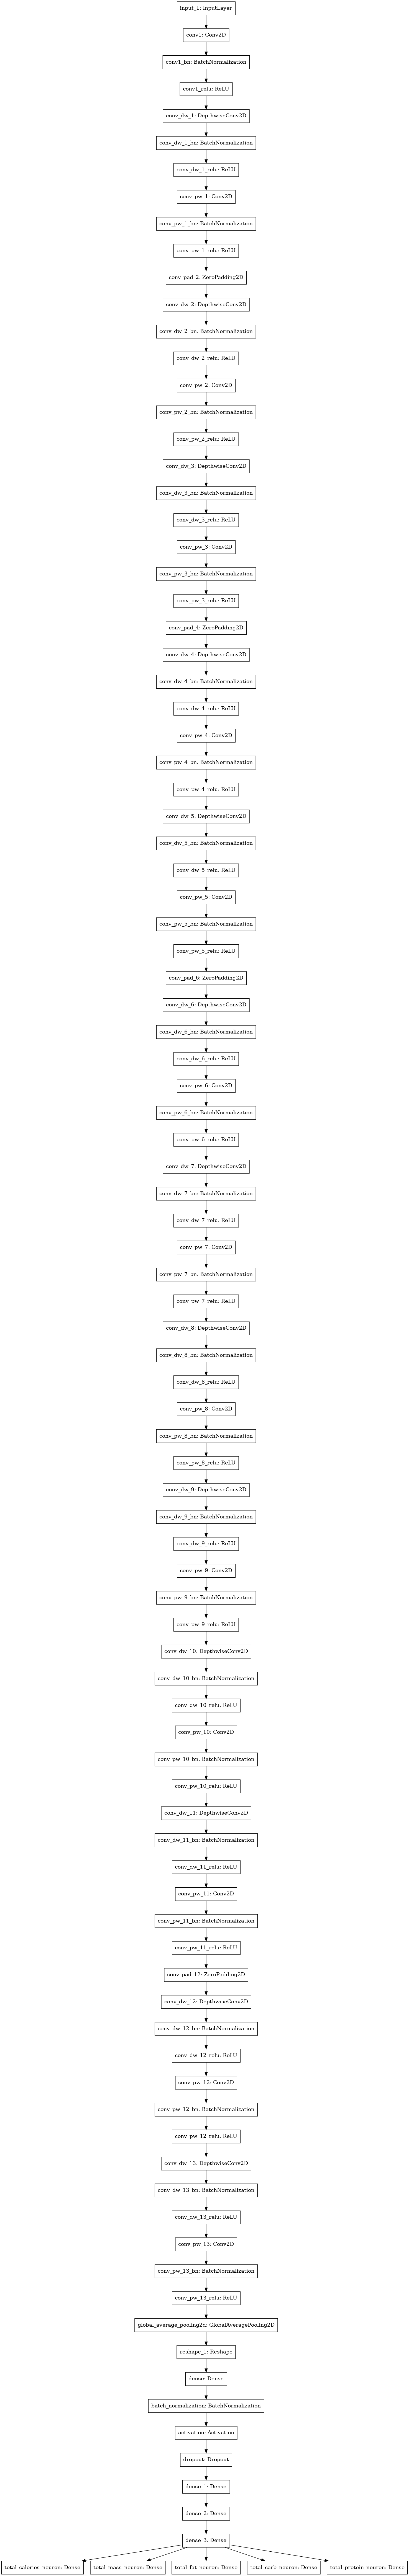

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model)

### Step 3.3: Model Optimizer

In [19]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

# model.compile(optimizer=Adam(lr=1e-5), loss='MAE')
# model.compile(optimizer=SGD(lr=1e-5, momentum=0.9), loss='MAE')
model.compile(optimizer=RMSprop(learning_rate=1e-5, momentum=0.9, centered=True), loss='MAE')

### Step 3.4: Model Checkpoint & EarlyStopping Callback

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# autosave best Model
checkpoint_path = './checkpoint/best_model_checkpoint'
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

### Step 3.5: Model Training

In [21]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=50, verbose=1, callbacks = [checkpoint, early])

2022-06-28 14:50:31.146830: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-28 14:50:36.219774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


173/173 [==============================] - 86s 435ms/step - loss: 0.8040 - total_calories_neuron_loss: 0.1515 - total_mass_neuron_loss: 0.1852 - total_fat_neuron_loss: 0.1549 - total_carb_neuron_loss: 0.1630 - total_protein_neuron_loss: 0.1494 - val_loss: 0.3750 - val_total_calories_neuron_loss: 0.0677 - val_total_mass_neuron_loss: 0.0759 - val_total_fat_neuron_loss: 0.0723 - val_total_carb_neuron_loss: 0.0871 - val_total_protein_neuron_loss: 0.0720

Epoch 00001: val_loss improved from inf to 0.37499, saving model to ./checkpoint/best_model_checkpoint


2022-06-28 14:52:01.926424: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
173/173 [==============================] - 75s 432ms/step - loss: 0.4191 - total_calories_neuron_loss: 0.0827 - total_mass_neuron_loss: 0.0900 - total_fat_neuron_loss: 0.0824 - total_carb_neuron_loss: 0.0837 - total_protein_neuron_loss: 0.0803 - val_loss: 0.2606 - val_total_calories_neuron_loss: 0.0586 - val_total_mass_neuron_loss: 0.0528 - val_total_fat_neuron_loss: 0.0491 - val_total_carb_neuron_loss: 0.0507 - val_total_protein_neuron_loss: 0.0494

Epoch 00002: val_loss improved from 0.37499 to 0.26059, saving model to ./checkpoint/best_model_checkpoint
Epoch 3/50
173/173 [==============================] - 74s 427ms/step - loss: 0.3102 - total_calories_neuron_loss: 0.0615 - total_mass_neuron_loss: 0.0638 - total_fat_neuron_loss: 0.0618 - total_carb_neuron_loss: 0.0611 - total_protein_neuron_loss: 0.0621 - val_loss: 0.1938 - val_total_calories_neuron_loss: 0.0396 - val_total_mass_neuron_loss: 0.0380 - val_total_fat_neuron_loss: 0.0355 - val_total_carb_neuron_loss: 0.0387 - 

# Step 4: Model Evaluation (On Valid Data)

In [22]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_path)

evaluation_results = model.evaluate(valid_batches, verbose=0)
print('valid_loss:', evaluation_results[0], '  \t', 'calories_loss:', evaluation_results[1])
print('mass_loss:', evaluation_results[2], ' \t', 'fats_loss:', evaluation_results[3])
print('carbs_loss:', evaluation_results[4], '\t', 'proteins_loss:', evaluation_results[5])

2022-06-28 15:35:57.611149: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ./checkpoint/best_model_checkpoint: Failed precondition: checkpoint/best_model_checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


valid_loss: 0.13597258925437927   	 calories_loss: 0.02722400240600109
mass_loss: 0.02700437232851982  	 fats_loss: 0.027243787422776222
carbs_loss: 0.027172738686203957 	 proteins_loss: 0.027327701449394226


### Step 4.1: Performance Visualizations

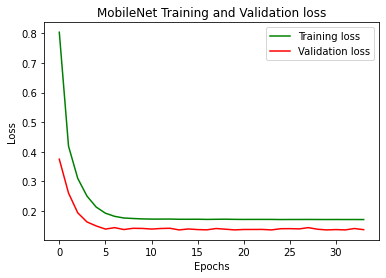

In [23]:
# summarize history for loss
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('MobileNet Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 5: Test Data Evaluation

### Step 5.1: Test Data Generator

In [24]:
labels = ["total_calories", "total_mass", "total_fat", "total_carb", "total_protein"]
test_datagen = ImageDataGenerator(rescale = 1/255.0)

test_batches = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory=test_dir,
                                                x_col="dishimage",
                                                y_col=labels,
                                                target_size=(IMG_DIMN, IMG_DIMN),
                                                class_mode="raw",
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

Found 340 validated image filenames.


### Step 5.2: Model Evalutaion (On Test Data)

In [25]:
evaluation_results = model.evaluate(test_batches, verbose=0)
print('test_loss:', evaluation_results[0], '  \t', 'calories_loss:', evaluation_results[1])
print('mass_loss:', evaluation_results[2], ' \t', 'fats_loss:', evaluation_results[3])
print('carbs_loss:', evaluation_results[4], '\t', 'proteins_loss:', evaluation_results[5])

test_loss: 0.14585939049720764   	 calories_loss: 0.029194489121437073
mass_loss: 0.02900920808315277  	 fats_loss: 0.029208412393927574
carbs_loss: 0.029151180759072304 	 proteins_loss: 0.029296092689037323


### Step 5.3: Use Case Evaluation

In [26]:
# get the max values to de-normalize the outputs
import pandas as pd
df_outputs_max_values = pd.read_csv('./outputs_max_values.csv')
max_calorie = df_outputs_max_values.iloc[0][0]
max_mass = df_outputs_max_values.iloc[0][1]
max_fat = df_outputs_max_values.iloc[0][2]
max_carb = df_outputs_max_values.iloc[0][3]
max_protein = df_outputs_max_values.iloc[0][4]

In [27]:
# function to display the actual nutrition's outputs for an image
def print_img_nutritions(img):
    for index, row in df_test.iterrows():
        if img == row['dishimage']:
            print('total_calories: ', row['total_calories']*max_calorie)
            print('total_mass: ', row['total_mass']*max_mass)
            print('total_fat: ', row['total_fat']*max_fat)
            print('total_carb: ', row['total_carb']*max_carb)
            print('total_protein: ', row['total_protein']*max_protein)
            break

In [28]:
import cv2
# resize the image to 224x224 & normalize it in range of [0-1]
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_DIMN, IMG_DIMN))
    img = (img / 255.0)
    return img

image:  dish_1565894910.png


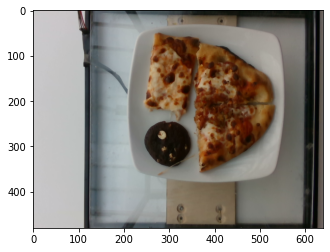

total_calories:  537.113037109375
total_mass:  179.0
total_fat:  21.35300064086914
total_carb:  67.94500732421875
total_protein:  18.191
**************
calories:  [[[[163.86407]]]]
mass:  [[[[129.92465]]]]
fat:  [[[[15.235878]]]]
carb:  [[[[14.000034]]]]
protein:  [[[[2.6324003]]]]


In [29]:
import os
import random
import numpy as np

# get random image from test data
rnd_tst_img = random.choice(os.listdir(test_dir))
rnd_tst_img_path = os.path.join(test_dir, rnd_tst_img)
print('image: ', rnd_tst_img)

# display the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(rnd_tst_img_path)
imgplot = plt.imshow(img)
plt.show()

# print the true 5 outputs from the df_test (after de-normalization)
print_img_nutritions(rnd_tst_img)

print("**************")

# preprocess the image (scale it by 1./255.)
preprocessed_img = preprocess_image(rnd_tst_img_path)

# reshape to 4d nparray
img_list = []
img_list.append(np.array(preprocessed_img))
preprocessed_reshaped_img = np.asarray(img_list)

# predict the image as numpy array
outputs = model.predict(x=preprocessed_reshaped_img)
print('calories: ', outputs[0]*max_calorie)
print('mass: ', outputs[1]*max_mass)
print('fat: ', outputs[2]*max_fat)
print('carb: ', outputs[3]*max_carb)
print('protein: ', outputs[4]*max_protein)

# Step 6: Save the Model

In [30]:
model.save("saved_model.h5")